In [322]:
import pandas as pd
import numpy as np
from openai import OpenAI, Embedding
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
import os


In [326]:
df = pd.read_csv("../word-dropout/11_20_26_27_Articles_DROPOUT.csv") 
queries = pd.read_csv("../queries_for_documents.csv")
#openai_client = OpenAI(api_key = 'insert-api-key')

In [237]:
print(df.head())

   id          title                                                url  \
0   0  Yahoo Finance  https://finance.yahoo.com/news/threads-now-let...   
1   1  Yahoo Finance  https://finance.yahoo.com/news/elon-musk-calls...   
2   2  Yahoo Finance  https://finance.yahoo.com/news/tpg-angelo-gord...   
3   3  Yahoo Finance  https://finance.yahoo.com/news/microsoft-faces...   
4   4  Yahoo Finance  https://finance.yahoo.com/news/crowdstrike-fal...   

                          date  \
0  Wed, Nov 27, 2024, 12:15 PM   
1   Wed, Nov 27, 2024, 1:34 PM   
2  Wed, Nov 27, 2024, 11:23 AM   
3  Wed, Nov 27, 2024, 12:58 PM   
4   Wed, Nov 27, 2024, 6:40 AM   

                                             content  \
0  Threads is rolling out a redesign that keeps y...   
1  Billionaire Elon Musk, a key adviser to the in...   
2  (Bloomberg) -- Americans borrowing against the...   
3  (Bloomberg) -- The US Federal Trade Commission...   
4  (Bloomberg) -- CrowdStrike Holdings Inc. fell ...   

       

In [216]:
print(queries.head())

                                               query  doc_index
0  Why is Australia's monetary policy still seen ...        551
1  What's Palo Alto Networks' revenue forecast fo...        400
2  How could institutional investments affect Bit...        377
3  Hey, I've been hearing that some AI companies ...        240
4  What impact could increased tariffs have on th...        516


In [190]:
from openai import OpenAI, Embedding


def summarize_doc(openai_client, text):
    query = "Summarize this into less than 10 words"

    prompt = f"Context:\n{text}\n\nQuestion: {query}\nAnswer:"


    completion = openai_client.chat.completions.create(
        model="gpt-3.5-turbo-0125",
        messages=[
        {"role": "user", "content": prompt}
        ]
    )

    print(completion.choices[0].message)

In [232]:
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

def preprocess_text(text):
    """Preprocess a single text input (either document or query) and use word stems."""
    stop_words = set(stopwords.words('english'))
    stop_words.add('would')  # Add custom stop words if needed
    translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))  # Replace punctuation with spaces
    text_nopunct = text.translate(translator)  # Remove punctuation
    words_list = text_nopunct.strip().split()  # Tokenize into words
    stemmer = PorterStemmer()
    filtered_words = [stemmer.stem(word.lower()) for word in words_list if word.lower() not in stop_words and len(word) > 1]
    return filtered_words

def preprocess_df(df):
    """Preprocess a DataFrame column containing document content."""
    df["content"] = df["content"].apply(preprocess_text)
    for p in [0.1, 0.3, 0.5, 0.7, 0.9]:
        df[f"reduced_content_p={p}"] = df[f"reduced_content_p={p}"].apply(preprocess_text)
    return df

def preprocess_query(query):
    """Preprocess a query string."""
    return preprocess_text(query)


In [300]:
import bm25
import importlib

# Reload the module after making changes
importlib.reload(bm25)

# Initialize the BM25 instance

def rank_query_bm25(bm25, query, ground_truth_index, top_k=5, summarize_docs=True, only_scores=False):
    # Display initial document details

    if not only_scores:
        print("=" * 50)
        print("📄 Document Sample:")
        print(df.head())
        print("=" * 50)
        print(f"📏 Total Documents: {len(bm25_instance.doc_lengths)}")
        print(f"Preprocessed query: {query} with doc_index {ground_truth_index}")
    # Rank documents for a given query
    ranked_indices, scores = bm25_instance.rank(query)

    ranked_indices = ranked_indices[:top_k]
    scores = scores[:top_k]

    if not only_scores:
        print("\n🏆 Ranking Results:")
        print("=" * 50)
        for i, (doc_index, score) in enumerate(zip(ranked_indices, scores), start=1):
            print(f"⭐ Rank {i}:")
            print(f"   - Document Index: {doc_index}")
            print(f"   - BM25 Score: {score:.4f}")
            doc_content = df.iloc[doc_index]["content"]
            if (summarize_docs):
                summmary = summarize_doc(openai_client, doc_content)
                print(f"   - Document Content:\n{summmary}")
            else:
                print(f"   - Document Content:\n{doc_content}")
            print("-" * 50)
    return ranked_indices, scores

    
    


In [327]:
df = preprocess_df(df)

In [159]:
print(df.head())

   id          title                                                url  \
0   0  Yahoo Finance  https://finance.yahoo.com/news/threads-now-let...   
1   1  Yahoo Finance  https://finance.yahoo.com/news/elon-musk-calls...   
2   2  Yahoo Finance  https://finance.yahoo.com/news/tpg-angelo-gord...   
3   3  Yahoo Finance  https://finance.yahoo.com/news/microsoft-faces...   
4   4  Yahoo Finance  https://finance.yahoo.com/news/crowdstrike-fal...   

                          date  \
0  Wed, Nov 27, 2024, 12:15 PM   
1   Wed, Nov 27, 2024, 1:34 PM   
2  Wed, Nov 27, 2024, 11:23 AM   
3  Wed, Nov 27, 2024, 12:58 PM   
4   Wed, Nov 27, 2024, 6:40 AM   

                                             content  \
0  [threads, rolling, redesign, keeps, feeds, vis...   
1  [billionaire, elon, musk, key, adviser, incomi...   
2  [bloomberg, americans, borrowing, homes, surge...   
3  [bloomberg, us, federal, trade, commission, op...   
4  [bloomberg, crowdstrike, holdings, inc, fell, ...   

       

In [328]:
import numpy as np
import time

# Assuming bm25_instance, preprocess_query, rank_query_bm25, and other dependencies are defined

# Initialize results and performance arrays
results = np.zeros((6, 4))  # For storing Precision at 10, 5, 3, 1 for each p
comp_time = np.zeros(6)     # For overall performance (average precision)
average_times = np.zeros(6) # To store average times over 100 iterations

# Mocking `queries` and `df` for demonstration purposes
queries = queries[25:]  # Slice to remove the first 25 queries
p_values = [0, 0.1, 0.3, 0.5, 0.7, 0.9]

# Repeat the experiment 100 times
for iteration in range(100):
    i = 0
    current_docs = df["content"]

    for p in p_values:
        if p > 0:
            current_docs = df[f"reduced_content_p={p}"]  # Get the document content for this p-value

        bm25_instance = bm25.BM25(current_docs, k1=1.5, b=0.75)

        top1, top3, top5, top10 = 0, 0, 0, 0
        total_queries = len(queries)

        # Start timing the ranking process
        start_time = time.time()

        # Loop over each query
        for idx, row in queries.iterrows():
            query = row["query"]
            doc_index = row["doc_index"]
            query = preprocess_query(query)

            # Rank documents for the current query
            ranked_indices, scores = rank_query_bm25(
                bm25_instance, query, doc_index, top_k=10, summarize_docs=False, only_scores=True
            )

            # Check if the doc_index is in the top 10, 5, 3, and 1
            if doc_index in ranked_indices:
                if doc_index in ranked_indices[:10]:
                    top10 += 1
                if doc_index in ranked_indices[:5]:
                    top5 += 1
                if doc_index in ranked_indices[:3]:
                    top3 += 1
                if doc_index in ranked_indices[:1]:
                    top1 += 1

        # End timing the ranking process
        elapsed_time = time.time() - start_time

        # Update timing and performance metrics
        results[i, :] += [top10 / total_queries, top5 / total_queries, top3 / total_queries, top1 / total_queries]
        comp_time[i] += elapsed_time

        i += 1

# Calculate the average precision and speed for each p
average_precision = results / 100
average_times = comp_time / 100

# Print the average precision and average times
for i, p in enumerate(p_values):
    print(f"Results for p={p}:")
    print(f"Average Precision at 10: {average_precision[i, 0]:.4f}")
    print(f"Average Precision at 5: {average_precision[i, 1]:.4f}")
    print(f"Average Precision at 3: {average_precision[i, 2]:.4f}")
    print(f"Average Precision at 1: {average_precision[i, 3]:.4f}")
    print(f"Average Time taken: {average_times[i]:.4f} seconds\n")



Results for p=0:
Average Precision at 10: 0.8800
Average Precision at 5: 0.8400
Average Precision at 3: 0.8000
Average Precision at 1: 0.6600
Average Time taken: 0.4811 seconds

Results for p=0.1:
Average Precision at 10: 0.8800
Average Precision at 5: 0.8400
Average Precision at 3: 0.8200
Average Precision at 1: 0.6600
Average Time taken: 0.4600 seconds

Results for p=0.3:
Average Precision at 10: 0.8600
Average Precision at 5: 0.8200
Average Precision at 3: 0.8000
Average Precision at 1: 0.6800
Average Time taken: 0.4169 seconds

Results for p=0.5:
Average Precision at 10: 0.8600
Average Precision at 5: 0.7400
Average Precision at 3: 0.7000
Average Precision at 1: 0.5600
Average Time taken: 0.3671 seconds

Results for p=0.7:
Average Precision at 10: 0.7400
Average Precision at 5: 0.6000
Average Precision at 3: 0.5600
Average Precision at 1: 0.4400
Average Time taken: 0.3011 seconds

Results for p=0.9:
Average Precision at 10: 0.4600
Average Precision at 5: 0.3600
Average Precision at

In [339]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages

# Create a PDF to save the plots
with PdfPages('precision_at_k.pdf') as pdf_pages:

    # First plot (Precision at different ranks)
    fig, ax = plt.subplots(figsize=(10, 6))
    p_values = [0, 0.1, 0.3, 0.5, 0.7, 0.9]
    labels = ['Precision at 10', 'Precision at 5', 'Precision at 3', 'Precision at 1']

    for i in range(4):
        ax.plot(p_values, average_precision[:, i], label=labels[i], marker='o')

    ax.set_xlabel('p Value')
    ax.set_ylabel('Precision')
    ax.set_title('Precision at different ranks (1, 3, 5, 10) for different p values')
    ax.legend()

    plt.grid(True)
    pdf_pages.savefig(fig)  # Save the first plot
    plt.close(fig)

In [338]:
    # Second plot (Computation Time for different p values)
with PdfPages('computation_time.pdf') as pdf_pages:
        fig, ax2 = plt.subplots(figsize=(10, 6))
    
        ax2.plot(p_values, average_times, marker='o', color='b')
    
        ax2.set_xlabel('p Value')
        ax2.set_ylabel('Time (s)')
        ax2.set_title('Computation Time for different p values')
        ax2.set_ylim(0, 0.5)  # Set y-axis to range from 0 to 50
        ax2.legend()
    
        plt.grid(True)
        pdf_pages.savefig(fig)  # Save the second plot
        plt.close(fig)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


C:\Users\Tobia\AppData\Local\Temp\ipykernel_24956\1697667806.py:6: MatplotlibDeprecationWarning: Keeping empty pdf files is deprecated since 3.8 and support will be removed two minor releases later.
  with PdfPages('precision_at_k.pdf') as pdf_pages:


ValueError: x and y must have same first dimension, but have shapes (6,) and (1,)

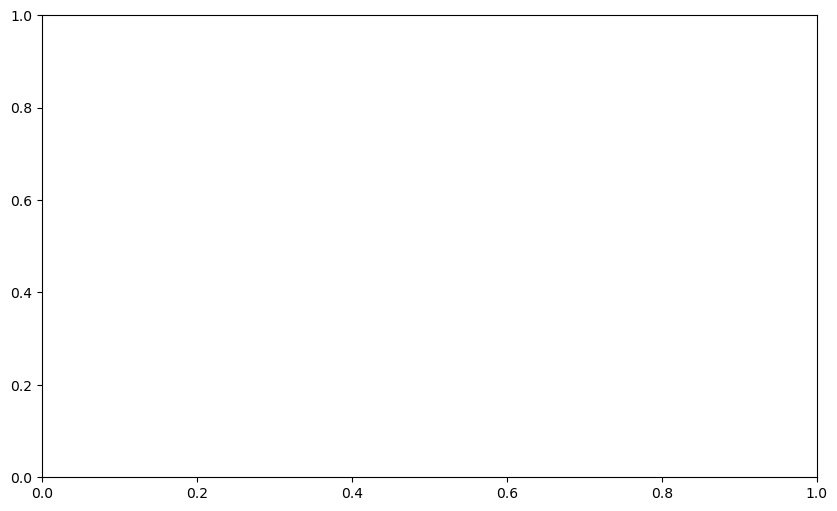

In [334]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages

# Create a PDF to save the plots
with PdfPages('precision_at_k.pdf') as pdf_pages:

    # First plot (Precision at different ranks)
    fig, ax = plt.subplots(figsize=(10, 6))
    p_values = [0, 0.1, 0.3, 0.5, 0.7, 0.9]
    labels = ['Time in (s)']

    ax.plot(p_values, average_times[i], label=labels[i], marker='o')

    ax.set_xlabel('p Value')
    ax.set_ylabel('Precision')
    ax.set_title('Precision at different ranks (1, 3, 5, 10) for different p values')
    ax.legend()

    plt.grid(True)
    pdf_pages.savefig(fig)  # Save the first plot
    plt.close(fig)

In [337]:
print(average_times)

[0.48112059 0.45995869 0.41694276 0.36711639 0.3010758  0.20376752]


In [131]:
count=0
for i in range(len(df)):
    article = df.iloc[i]["content"]
    if len(article) < 100:
        count+=1
        print(article)
print(count)

US benchmark equity indexes were lower intraday as traders assessed the latest economic data. The
Equity Markets Fall Intraday Ahead of Nvidia Earnings
Wells Fargo Raises S&P 500 Target Level for Next Year Amid Economic Strength, Policy Changes
3


In [174]:
df.iloc[33]["content"]

'Stock up the eggnog\xa0—\xa0you\'re gonna need it. The holidays are here and that means joy to the world, coming together with your loved ones and spending a ton of money on gifts. Related: Fed inflation gauge ticked higher in October amid consumer spending boost This is the most important time of the year for retailers, given the spike in consumer spending. Holiday shopping is crucial for the chains\' overall sales. The National Retail Federation\xa0expects holiday sales to grow between 2.5% and 3.5% from a year earlier, to a total of $980 billion from $955 billion. The forecast includes e-commerce, which is expected to grow 8% to 9%, totaling between $295 billion and $300 billion. 🚨Don’t Miss this amazing Black Friday Move! Get 60% off TheStreet Pro. Act now before it’s gone 😲 “I am optimistic about the pace of economic activity in the final quarter of the year,” Jack Kleinhenz, the trade group\'s chief economist, said. "Given third-quarter spending performance and comprehensive upw

In [297]:
df.iloc[528]["content"]

'The vibe on Wall Street post-Donald Trump\'s reelection: Bring on the good times. “This election was about whether you were more scared of four years of the same or more scared of four years of change,” Apollo Global (APO) co-founder and CEO Marc Rowan said at Yahoo Finance\'s Invest conference. (Disclosure: Yahoo Finance is owned by Apollo Global Management.) Rowan, who is now being floated as a potential Treasury Secretary pick in the incoming Trump administration, added that the "market\'s verdict\'s been rendered.” “I think this administration has a remarkable chance to really pivot the country to take advantage of all the inherent positives that we have,” Rowan said. Rowan’s optimism matches that of the market, with the S&P 500 rallying above 6,000 in the best post-election day melt-up of all time. Experts say the rally is based in part on Trump\'s policy proposals around making tax cuts permanent and loosening regulations. But that rally and optimism may be ignoring a tariffs-le

In [166]:
df.iloc[55]["reduced_content_p=0.5"]

"(Bloomberg) -- SoftBank to stake in acquiring up to $1.5 billion shares employees, according to with the matter. Most Read from New York ‘Living Breakwaters’ Seas City, Car-Free Options In Designed for Women’s Sports Takes NYC's Underground System Key NYC Gets for Homes $5 Billion Pledge The will a tender for the to shares they OpenAI’s billion October, but pushed a larger allocation at time, one of people, asking to be named the negotiations founder has vowed investments as his company regains after OpenAI, which jumped out to early leadership the with at billion last fundraising. not how stock SoftBank be able buy from may hold onto they forecast ahead. and didn’t respond to requests comment of business The tender offer is to close this week, according to first reported the Bloomberg When Hospitals Big Team Budget-Slashing MAGA Billionaires Takes Shape Flying Feels Worse Charm Bracelet Shop Viral Schools Growing Enrollment ©2024"

In [194]:
queries.iloc[22]["query"]

'How did the potential cease-fire between Israel and Hezbollah affect oil prices, and why are traders anticipating a reduction in supply risks?'

In [246]:
df.iloc[161]

id                                                                     161
title                                                        Yahoo Finance
url                      https://finance.yahoo.com/news/dei-rollback-re...
date                                            Tue, Nov 26, 2024, 9:07 AM
content                  Walmart (WMT) is scaling back some of its dive...
reduced_content_p=0.1    Walmart (WMT) is scaling back some of its dive...
reduced_content_p=0.3    is scaling back some of its diversity initiati...
reduced_content_p=0.5    Walmart is of diversity initiatives, one of th...
reduced_content_p=0.7    scaling prominent companies make as largest th...
reduced_content_p=0.9    chain it using participate a be sunsetted mark...
Name: 161, dtype: object

In [244]:
df.iloc[218]

id                                                                     218
title                                                        Yahoo Finance
url                      https://finance.yahoo.com/news/dei-rollback-re...
date                                            Tue, Nov 26, 2024, 9:07 AM
content                  Walmart (WMT) is scaling back some of its dive...
reduced_content_p=0.1    Walmart (WMT) is scaling back some of its dive...
reduced_content_p=0.3    Walmart (WMT) is back of diversity one of the ...
reduced_content_p=0.5    scaling some one of companies yet to as activi...
reduced_content_p=0.7    its of companies The Yahoo cease (diversity, a...
reduced_content_p=0.9    of its one the companies about-face pressure a...
Name: 218, dtype: object

In [292]:
df.iloc[201]["content"]

'A new president will enter the White House in 2025, but some debates remain the same. Wall Street analysts are split over the Federal Reserve’s next moves on interest rates, dissecting recent remarks from policymakers as 2024 nears its end. With just one Federal Open Market Committee (FOMC) meeting left this year, Jerome Powell and his colleagues are wrapping up a period marked by the first rate cuts in the current cycle. Optimists are hoping for a year-end rate cut in December, while others urge caution. Some banks project a steady path of cuts in 2025, potentially bringing rates to a neutral level of around 3.25%. But not everyone agrees. Analysts at firms like Deutsche Bank warn that incoming Trump-era policies, such as inflationary tariffs, could stall further rate reductions. "There\'s two things. One is just the details of the underlying economy that we see now, which is the consumer has remained resilient ... the labor market looks more resilient and more stable than what we th

In [294]:
df.iloc[462]["content"]

'The lead-up to Nvidia’s Wednesday’s earnings release produced plenty of jitters on Wall Street, despite expectations of incredible growth. The Q3 results, put out after the bell, did not prompt the massive sell-off some feared, with the AI chip leader’s stock dropping less than 2% in after-hours trading as management spoke to analysts on the call. Last quarter, a modest revenue and earnings beat was not enough to prevent a massive sell-the-news event, with the stock falling 18% in the week following the call. Some figured the stock could be due for another dip this time around with institutional investors eager to engage in profit-taking at the end the year. The stock held steady early Wednesday evening, however, as revenue jumped 94% year-over-year to $35.1 billion. The company’s January guidance also came in better than expected, with the chip maker indicating it is confident about the rollout of its next-generation Blackwell platform. “The age of AI is in full steam, propelling a g